# 5 决策树

决策树 (decision tree) 是形如 if-else 的分类方法. 决策树分类的好坏主要取决于各个条件的设计. 根据已有的训练数据, 决策树的重点是提取合适的特征条件.

为了选取"最有区分度"的特征, 可以利用信息熵的知识.

## 信息熵 

信息熵 (information entropy) 衡量信息量的多少. 对于一个离散概率分布
$$\mathbb P(X=X_i) = p_i \quad(i=1,2,\dotsc,n)$$
其熵定义为
$$H(\mathbb P) = -\sum_{i=1}^n p_i\log p_i$$

信息越混乱 (越不确定), 熵越大.

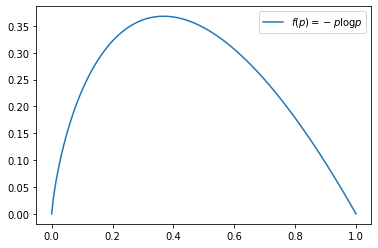

In [12]:
from matplotlib import pyplot as plt
import numpy as np
p = np.linspace(0, 1, 200)
h = -p * np.log(p + 1e-16) # + 1e-16 to prevent NaN
plt.plot(p, h)
plt.legend(['$f(p)=-p\log p$'])
plt.show()

### 条件熵

若离散分布 $Y$ 受到参数 $x$ 的影响, 当已先验地知道 $x$ 的分布 $X$ 时  (其中 $X$ 是离散分布), 可以定义条件熵 (conditional entropy) 
$$H(Y|X) = \mathbb E(H(Y)|X)= \sum_{i=1}^m p_iH(Y|X=x_i)$$

若离散分布 $Y$ 在未知与已知 $x\sim X$ 时的熵的变化称为信息增益 (information gain)
$$g(Y,X) = H(Y) - H(Y|X).$$

由于知道得多了, 信息更确定了, 信息熵一定减小, 即 $g\geqslant 0$.

证: 设离散分布 $Y$ 有 $n$ 类: $y_1,\dotsc,y_n$, 则
$$\begin{aligned}H(Y|X)& =  \sum_{i=1}^m \sum_{j=1}^np_i \mathbb P(Y = y_j|X=x_i)\\ & 
=\sum_{i=1}^m \sum_{j=1}^np_i \frac{\mathbb P(Y = y_j, X=x_i)}{p_i}\log \left(\frac{p_i}{\mathbb P(Y = y_j, X=x_i)}\right) \\ &= \sum_{i=1}^m \sum_{j=1}^n \mathbb P(Y = y_j, X=x_i)\left\{\log \left(\frac{p_i\mathbb P(Y = y_j)}{\mathbb P(Y = y_j, X=x_i)} \right) - \log \mathbb P(Y = y_j)\right\}

\\ & \leqslant \sum_{i=1}^m \sum_{j=1}^n \mathbb P(Y = y_j, X=x_i) \left\{  \left(\frac{p_i\mathbb P(Y = y_j)}{\mathbb P(Y = y_j, X=x_i)}-1 \right) - \log \mathbb P(Y = y_j)\right\}
 \\ &= \sum_{j=1}^n \sum_{i=1}^m \left(p_i\mathbb P(Y = y_j)-\mathbb P(Y = y_j, X=x_i) - \mathbb P(Y = y_j, X=x_i)\log \mathbb P(Y = y_j)\right) 
 \\ &= \sum_{j=1}^n  \left(\mathbb P(Y = y_j)-\mathbb P(Y = y_j) - \mathbb P(Y = y_j)\log \mathbb P(Y = y_j)\right)
 \\ &= H(Y)
\end{aligned}$$

注: 信息增益其实是一种 KL 散度 (Kullback-Leibler Divergence).
$$g(Y,X) = KL(p(X,Y)\Vert p(X)p(Y))=g(X,Y)$$

## 特征选择

类似于前向选择 (forward selection).

### ID3算法

每次选取信息增益最大的特征, 作为分类的特征.

### C4.5算法

定义信息增益比 $g_R(Y,X) = \dfrac{g(Y,X)}{H(X)}$. 每次选取信息增益比最大的特征, 作为分类的特征.